In [1]:
from tqdm import tqdm
import torchvision
from glob import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import transforms
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import numpy as np
from PIL import Image
from torchvision.datasets import CelebA
import torch.nn.functional as F
from pprint import pprint
from torchvision import models

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1, 2'

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [4]:
class CelebA_Smile(CelebA):
    def __getitem__(self, index):
        X = Image.open(os.path.join(self.root, self.base_folder, "img_align_celeba", self.filename[index]))

        target = []
        for t in self.target_type:
            if t == "attr":
                target.append(self.attr[index, 31:32]) # Smiling
            elif t == "identity":
                target.append(self.identity[index, 0])
            elif t == "bbox":
                target.append(self.bbox[index, :])
            elif t == "landmarks":
                target.append(self.landmarks_align[index, :])
            else:
                raise ValueError("Target type \"{}\" is not recognized.".format(t))
        target = tuple(target) if len(target) > 1 else target[0]

        if self.transform is not None:
            X = self.transform(X)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return X, target

In [5]:
train_dl = CelebA_Smile(root="/data/local/qipan/exp_celeba/datasets/celeba", download=False, transform=train_transform)
# valid_dl = CelebA_Male(root="/data/local/qipan/exp_celeba/datasets/celeba", download=False, transform=test_transform)
val_num = train_dl.__len__()//100
_, valid_dl = torch.utils.data.random_split(train_dl, [train_dl.__len__()-val_num, val_num])
print(valid_dl.__len__())

1627


In [6]:
len(train_dl), len(valid_dl)

(162770, 1627)

In [7]:
# count
count = 0
for x, y in train_dl:
    if y == 1:
        count += 1
print(count)

78080


In [6]:
x, y = train_dl[0]

In [7]:
x.shape

torch.Size([3, 128, 128])

In [8]:
y, y.shape

(tensor([1]), torch.Size([1]))

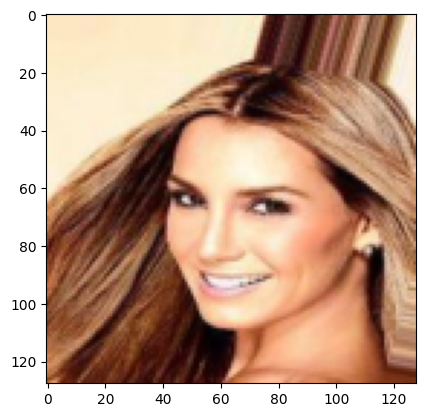

In [7]:
plt.imshow(torchvision.utils.make_grid(train_dl[0][0]).permute(1, 2, 0))

In [8]:
class CustomResNet50Model(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet50Model, self).__init__()
        
        # Load the pretrained ResNet-50 model + higher level layers
        self.resnet50 = models.resnet50(pretrained=True)
        
        # Remove the final layer (classification head of original ResNet50)
        # To keep the feature extraction layers only
        self.features = nn.Sequential(*list(self.resnet50.children())[:-1])
        
        # Freeze the parameters of ResNet50 (make them non-trainable)
        for param in self.features.parameters():
            param.requires_grad = False
        
        # Define new classification head
        self.class_head = nn.Sequential(
            nn.Linear(self.resnet50.fc.in_features, num_classes), 
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features(x)
        
        # Global Average Pooling (GAP) layer
        x = x.mean([2, 3])
        
        # Classification head
        x = self.class_head(x)
        return x

In [9]:
def check_cuda():
    _cuda = False
    if torch.cuda.is_available():
        _cuda = True
    return _cuda

In [10]:
is_cuda = check_cuda()

model = CustomResNet50Model(num_classes=2)
if is_cuda:
    model.cuda()

/common/home/qx67/Desktop/dpgen/DPgan_model/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/common/home/qx67/Desktop/dpgen/DPgan_model/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
x = train_dl[0][0].unsqueeze(0).cuda()

In [14]:
x.shape

torch.Size([1, 3, 128, 128])

In [15]:
model(x).shape

torch.Size([1, 2])

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dl, shuffle = True, batch_size = 4, num_workers = 4)
valid_dataloader = torch.utils.data.DataLoader(valid_dl, shuffle = True, batch_size = 4, num_workers = 4)

In [12]:
def pred_acc(original, predicted):
    return torch.round(predicted).eq(original).sum().numpy()/len(original)


In [18]:
criterion = nn.BCELoss()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
optimizer = optim.Adam(model.class_head.parameters(), lr = 0.001, weight_decay = 0.001)


In [19]:
def fit_model(epochs, model, dataloader, phase = 'training', volatile = False):
    
    pprint("Epoch: {}".format(epochs))

    if phase == 'training':
        model.train()
        
    if phase == 'validataion':
        model.eval()
        volatile = True
        
    running_loss = []
    running_acc = []
    b = 0
    for i, data in enumerate(dataloader):
        inputs, target = data[0].cuda(), torch.eye(2)[data[1]].squeeze().cuda() 
        inputs, target = Variable(inputs), Variable(target)
        
        if phase == 'training':
            optimizer.zero_grad()
            
        ops = model(inputs)
        
        acc_ = []
        for i, d in enumerate(ops):
           
            acc = pred_acc(torch.Tensor.cpu(target[i]), torch.Tensor.cpu(d))
            acc_.append(acc)

        loss = criterion(ops, target)
                
        running_loss.append(loss.item())
        running_acc.append(np.asarray(acc_).mean())
        b += 1
       
        if phase == 'training':
            
            loss.backward()
        
            optimizer.step()
            
    total_batch_loss = np.asarray(running_loss).mean()
    total_batch_acc = np.asarray(running_acc).mean()
    

    pprint("{} loss is {} ".format(phase,total_batch_loss))
    pprint("{} accuracy is {} ".format(phase, total_batch_acc))
    
    return total_batch_loss, total_batch_acc


In [20]:
inputs, target = next(iter(train_dataloader))

In [21]:
ops = model(inputs.cuda())

In [22]:
trn_losses = []; trn_acc = []
val_losses = []; val_acc = []


In [23]:
torch.cuda.empty_cache()
for i in tqdm(range(100)):
    trn_l, trn_a = fit_model(i, model, train_dataloader)
    val_l, val_a = fit_model(i, model, valid_dataloader, phase = 'validation')
    trn_losses.append(trn_l); trn_acc.append(trn_a)
    val_losses.append(val_l); val_acc.append(val_a)


  0%|          | 0/100 [00:00<?, ?it/s]

'Epoch: 0'
'training loss is 0.6341922057621605 '
'training accuracy is 0.7001388445187133 '
'Epoch: 0'


  1%|          | 1/100 [06:02<9:58:37, 362.80s/it]

'validation loss is 0.5406453359496828 '
'validation accuracy is 0.740990990990991 '
'Epoch: 1'


In [ ]:
torch.save(model.state_dict(), '/data/local/qipan/exp_celeba/celeba_cls_smile.pth')

In [13]:
# test process
test_dl = CelebA_Smile(root="/data/local/qipan/exp_celeba/datasets/celeba", 
                       download=False, transform=train_transform, split='test')

In [14]:
len(test_dl)

19962

In [18]:
test_dataLoader = torch.utils.data.DataLoader(valid_dl, shuffle = True, batch_size = 1, num_workers = 4)

In [16]:
model.load_state_dict(torch.load('/data/local/qipan/exp_celeba/celeba_cls_smile_50.pth'))
model.eval()

CustomResNet50Model(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [20]:
cnt = 0
for i, data in enumerate(test_dataLoader):
        cnt += 1
        inputs, target = data[0].cuda(), torch.eye(2)[data[1]].squeeze().cuda()
        # print(inputs.shape, target.shape)
        inputs, target = Variable(inputs), Variable(target)
        pred = model(inputs)
        print("prediction: ", torch.argmax(pred))
        print("label: ", torch.argmax(target))

        '''acc_ = []
        for i, d in enumerate(pred):
            acc = pred_acc(torch.Tensor.cpu(target[i]), torch.Tensor.cpu(d))
            acc_.append(acc)
        print("average accuracy: ", np.asarray(acc_).mean())'''
        if cnt == 100:
            break

prediction:  tensor(1, device='cuda:0')
label:  tensor(1, device='cuda:0')
prediction:  tensor(1, device='cuda:0')
label:  tensor(1, device='cuda:0')
prediction:  tensor(1, device='cuda:0')
label:  tensor(1, device='cuda:0')
prediction:  tensor(1, device='cuda:0')
label:  tensor(1, device='cuda:0')
prediction:  tensor(1, device='cuda:0')
label:  tensor(0, device='cuda:0')
prediction:  tensor(1, device='cuda:0')
label:  tensor(1, device='cuda:0')
prediction:  tensor(1, device='cuda:0')
label:  tensor(1, device='cuda:0')
prediction:  tensor(1, device='cuda:0')
label:  tensor(1, device='cuda:0')
prediction:  tensor(0, device='cuda:0')
label:  tensor(0, device='cuda:0')
prediction:  tensor(1, device='cuda:0')
label:  tensor(1, device='cuda:0')
prediction:  tensor(1, device='cuda:0')
label:  tensor(1, device='cuda:0')
prediction:  tensor(1, device='cuda:0')
label:  tensor(0, device='cuda:0')
prediction:  tensor(1, device='cuda:0')
label:  tensor(1, device='cuda:0')
prediction:  tensor(1, de

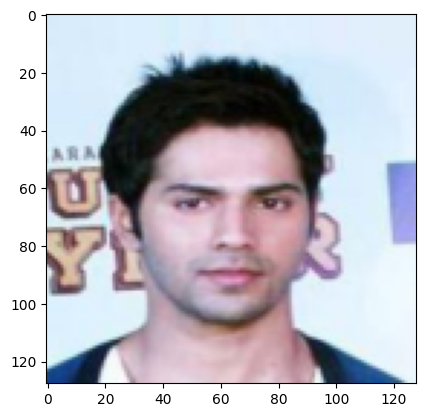

In [27]:
plt.imshow(torchvision.utils.make_grid(test_dl[5][0]).permute(1, 2, 0))

In [29]:
test_dl[5][1]

tensor([0])

In [30]:
torch.argmax(model(test_dl[5][0].unsqueeze(0).cuda()))

tensor(1, device='cuda:0')